In [87]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [88]:

def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data

def calculate_features(df):
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Moving Average Convergence Divergence (MACD)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Upper'] = df['BB_Middle'] + (df['Close'].rolling(window=20).std() * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['Close'].rolling(window=20).std() * 2)
    
    # Price momentum
    df['Momentum'] = df['Close'] - df['Close'].shift(4)
    
    # Volume features
    df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20']

    return df

def prepare_data(df, target_col, feature_cols, forecast_period, do_train_test_split=True):
    df['Target'] = df[target_col].shift(-forecast_period)
    df = df.dropna()

    # Create lagged features
    for col in feature_cols:
        for lag in [1, 3, 5]:
            df[f'{col}_Lag_{lag}'] = df[col].shift(lag)
    
    # Update feature columns list with new lagged features
    feature_cols = [col for col in df.columns if col.split('_')[0] in feature_cols or col.startswith('Lag')]

    # print(feature_cols)
    df = df.ffill()
    df = df.dropna()


    X = df[feature_cols].copy()
    y = df['Target'].copy()

    # if do_train_test_split:
    #     return feature_cols, train_test_split(X, y, test_size=0.2, random_state=42)
    # else:
    return feature_cols, X, y

def train_model(X_train, y_train):
    model = ElasticNet() # Lasso() # LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return mae, rmse

def plot_results(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Stock Prices')
    plt.show()

Mean Absolute Error: 55.35
Root Mean Squared Error: 69.64


/tmp/ipykernel_14345/3792864795.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_Lag_{lag}'] = df[col].shift(lag)
/tmp/ipykernel_14345/3792864795.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_Lag_{lag}'] = df[col].shift(lag)
/tmp/ipykernel_14345/3792864795.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

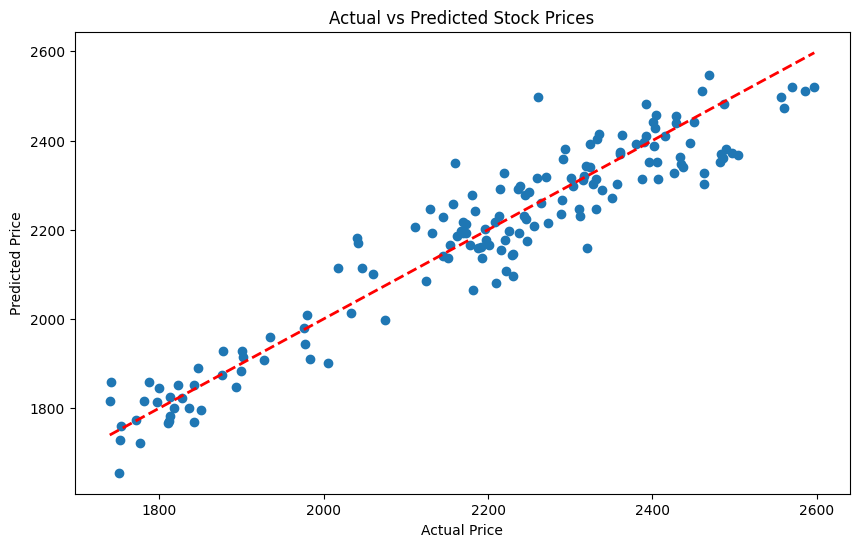

Estimated Fair Market Value: 2535.21


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


In [89]:


# Main execution
ticker = "RELIANCE.NS"  # Reliance Industries on NSE
start_date = "2020-01-01"
end_date = "2023-12-31"

# Fetch data
data = get_stock_data(ticker, start_date, end_date)

# Calculate features
data = calculate_features(data)

# Prepare data for modeling
# feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_200', 'Volatility']
# Select features
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                    'SMA_50', 'SMA_200', 'EMA_20', 'Volatility', 
                    'RSI', 'MACD', 'Signal_Line', 
                    'BB_Upper', 'BB_Middle', 'BB_Lower', 
                    'Momentum', 'Volume_Ratio']
feature_cols, X, y = prepare_data(data, 'Close', feature_cols, forecast_period=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = train_model(X_train, y_train)

# Evaluate model
mae, rmse = evaluate_model(model, X_test, y_test)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Plot results
plot_results(y_test, model.predict(X_test))

# Estimate current FMV
latest_data = X[feature_cols].iloc[-1].values.reshape(1, -1)
estimated_fmv = model.predict(latest_data)[0]
print(f"Estimated Fair Market Value: {estimated_fmv:.2f}")

In [56]:
data.head(10).T

Date,2020-01-01 00:00:00+05:30,2020-01-02 00:00:00+05:30,2020-01-03 00:00:00+05:30,2020-01-06 00:00:00+05:30,2020-01-07 00:00:00+05:30,2020-01-08 00:00:00+05:30,2020-01-09 00:00:00+05:30,2020-01-10 00:00:00+05:30,2020-01-13 00:00:00+05:30,2020-01-14 00:00:00+05:30
Open,1.363588e+03,1.358199e+03,1.377062e+03,1.365385e+03,1.364487e+03,1.360894e+03,1.382093e+03,1.394040e+03,1.387887e+03,1.383351e+03
High,1.371763e+03,1.384204e+03,1.384833e+03,1.372481e+03,1.378410e+03,1.378365e+03,1.392333e+03,1.399475e+03,1.400148e+03,1.392333e+03
Low,1.352360e+03,1.358199e+03,1.368080e+03,1.345623e+03,1.359546e+03,1.356402e+03,1.375491e+03,1.383036e+03,1.381913e+03,1.367047e+03
Close,1.356043e+03,1.379129e+03,1.380790e+03,1.348767e+03,1.369517e+03,1.359232e+03,1.390537e+03,1.390222e+03,1.386674e+03,1.373829e+03
Volume,7.002234e+06,8.855158e+06,1.049235e+07,1.225959e+07,8.341811e+06,8.023951e+06,7.491371e+06,6.239179e+06,9.141191e+06,7.908267e+06
Dividends,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Stock Splits,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SMA_50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SMA_200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EMA_20,1.356043e+03,1.358241e+03,1.360389e+03,1.359282e+03,1.360257e+03,1.360159e+03,1.363052e+03,1.365640e+03,1.367643e+03,1.368232e+03


In [57]:
data.tail(10).T

Date,2023-12-15 00:00:00+05:30,2023-12-18 00:00:00+05:30,2023-12-19 00:00:00+05:30,2023-12-20 00:00:00+05:30,2023-12-21 00:00:00+05:30,2023-12-22 00:00:00+05:30,2023-12-26 00:00:00+05:30,2023-12-27 00:00:00+05:30,2023-12-28 00:00:00+05:30,2023-12-29 00:00:00+05:30
Open,2.469618e+03,2.487159e+03,2.546358e+03,2.562353e+03,2.518453e+03,2.550942e+03,2.559314e+03,2.573266e+03,2.581040e+03,2.602268e+03
High,2.491544e+03,2.526326e+03,2.565194e+03,2.590059e+03,2.564795e+03,2.572170e+03,2.583183e+03,2.591106e+03,2.603165e+03,2.605158e+03
Low,2.461695e+03,2.482524e+03,2.516658e+03,2.511476e+03,2.509732e+03,2.539032e+03,2.554032e+03,2.564397e+03,2.578100e+03,2.570576e+03
Close,2.487159e+03,2.512473e+03,2.549447e+03,2.518602e+03,2.553882e+03,2.556374e+03,2.569330e+03,2.578100e+03,2.596737e+03,2.576206e+03
Volume,7.966076e+06,7.082594e+06,8.410302e+06,8.868361e+06,6.882727e+06,8.270892e+06,3.732832e+06,4.602078e+06,6.151318e+06,5.432292e+06
Dividends,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Stock Splits,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SMA_50,2.347422e+03,2.351545e+03,2.356408e+03,2.360577e+03,2.365845e+03,2.370961e+03,2.375605e+03,2.380338e+03,2.385446e+03,2.390248e+03
SMA_200,2.322622e+03,2.324281e+03,2.326178e+03,2.327846e+03,2.329763e+03,2.331900e+03,2.334004e+03,2.336234e+03,2.338285e+03,2.340126e+03
EMA_20,2.412465e+03,2.421989e+03,2.434128e+03,2.442173e+03,2.452812e+03,2.462675e+03,2.472833e+03,2.482858e+03,2.493704e+03,2.501561e+03


In [71]:
X_train.ffill()[X_train.isna().any(axis=1)]

,Open,High,Low,Close,Volume,Volatility,RSI,MACD,Momentum,Volume_SMA_20,...,RSI_Lag_5,MACD_Lag_1,MACD_Lag_3,MACD_Lag_5,Momentum_Lag_1,Momentum_Lag_3,Momentum_Lag_5,Volume_Ratio_Lag_1,Volume_Ratio_Lag_3,Volume_Ratio_Lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-19 00:00:00+05:30,1994.006474,2029.196711,1962.230607,1981.396240,15600192,0.230917,43.343855,6.046690,-95.145752,13184929.50,...,64.822395,67.913348,70.048875,65.743634,-0.685547,34.673584,109.410889,0.565494,0.616341,0.936963
2020-10-22 00:00:00+05:30,1936.964522,1941.607970,1903.822909,1918.345093,15401105,0.213921,31.601883,-11.877980,-62.686890,12483891.40,...,28.069669,-5.636571,6.046690,-19.203503,-74.568481,-95.145752,37.373291,1.332532,1.183184,1.642155
2020-10-23 00:00:00+05:30,1917.480323,1943.884351,1908.739749,1923.899292,11711062,0.201844,34.239447,-16.189542,-57.496948,12323786.55,...,66.512222,-11.877980,0.775486,24.631194,-62.686890,-119.819702,75.102661,1.233678,0.721609,1.451162
2020-10-20 00:00:00+05:30,1983.945640,1996.692424,1959.590115,1962.913452,9241144,0.221551,34.752883,0.775486,-119.819702,12806302.20,...,48.300649,6.046690,-8.776205,21.628197,-95.145752,-175.056885,-239.515381,1.183184,0.970346,1.071490


In [24]:
prepare_data(oot_data, 'Close', feature_cols, forecast_period=5, do_train_test_split=False)

(Empty DataFrame
 Columns: [Open, High, Low, Close, Volume, SMA_50, SMA_200, Volatility]
 Index: [],
 Series([], Name: Target, dtype: float64))

Mean Absolute Error: 80.40
Root Mean Squared Error: 97.77


/tmp/ipykernel_14345/3792864795.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_Lag_{lag}'] = df[col].shift(lag)
/tmp/ipykernel_14345/3792864795.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_Lag_{lag}'] = df[col].shift(lag)
/tmp/ipykernel_14345/3792864795.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

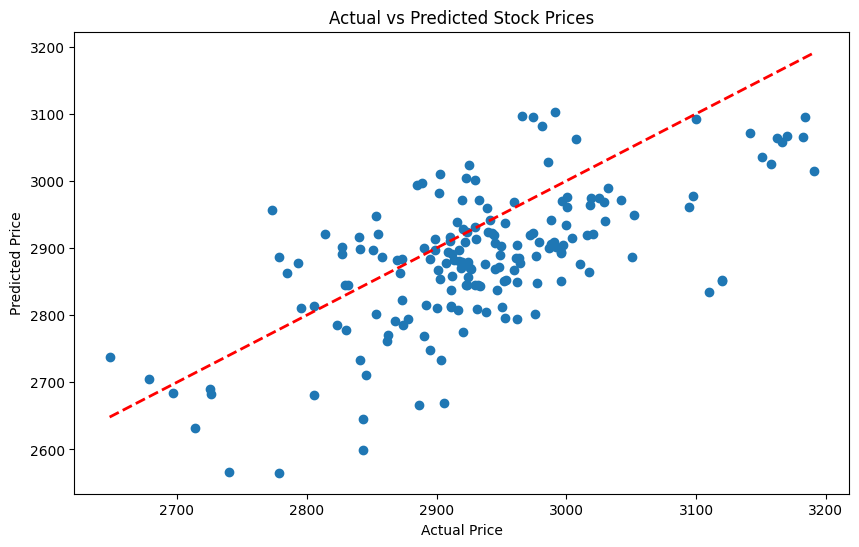

Estimated Fair Market Value: 2956.62


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


In [90]:
# Fetch OOT data
start_date = "2023-01-01"
end_date = "2024-10-05"
oot_data = get_stock_data(ticker, start_date, end_date)

# Calculate features
oot_data = calculate_features(oot_data)
# Keep only 2024 data
oot_data = oot_data[oot_data.index >= '2024-01-01']

# Prepare Data

feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                    'SMA_50', 'SMA_200', 'EMA_20', 'Volatility', 
                    'RSI', 'MACD', 'Signal_Line', 
                    'BB_Upper', 'BB_Middle', 'BB_Lower', 
                    'Momentum', 'Volume_Ratio']
feature_cols, oot_X, oot_y = prepare_data(oot_data, 'Close', feature_cols, forecast_period=5, do_train_test_split=False)

# Evaluate model
mae, rmse = evaluate_model(model, oot_X, oot_y)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Plot results
plot_results(oot_y, model.predict(oot_X))

# Estimate current FMV
latest_data = oot_X[feature_cols].iloc[-1].values.reshape(1, -1)
estimated_fmv = model.predict(latest_data)[0]
print(f"Estimated Fair Market Value: {estimated_fmv:.2f}")

In [91]:
model

ElasticNet()

In [25]:
oot_data.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_50,SMA_200,Daily_Return,Volatility,Target
Date,,,,,,,,,,,,
2024-09-20 00:00:00+05:30,2948.000000,2990.000000,2942.750000,2971.850098,15448660,0.0,0.0,2990.858872,NaN,0.011057,0.148427,3052.350098
2024-09-23 00:00:00+05:30,2982.000000,3003.000000,2977.899902,2986.750000,4416157,0.0,0.0,2987.581733,NaN,0.005014,0.146212,2953.149902
2024-09-24 00:00:00+05:30,2977.000000,3001.000000,2975.750000,2978.750000,8568722,0.0,0.0,2983.503770,NaN,-0.002678,0.143817,2929.649902
2024-09-25 00:00:00+05:30,2967.800049,2993.000000,2960.399902,2987.899902,3534501,0.0,0.0,2979.588872,NaN,0.003072,0.144248,2813.949951
2024-09-26 00:00:00+05:30,2981.300049,3008.000000,2976.100098,2995.899902,9409499,0.0,0.0,2976.670137,NaN,0.002677,0.133195,2773.050049
2024-09-27 00:00:00+05:30,2998.000000,3066.949951,2984.000000,3052.350098,10298739,0.0,0.0,2974.464814,NaN,0.018842,0.147536,NaN
2024-09-30 00:00:00+05:30,3038.800049,3049.949951,2948.800049,2953.149902,13504407,0.0,0.0,2971.532222,NaN,-0.032500,0.187594,NaN
2024-10-01 00:00:00+05:30,2961.300049,2975.899902,2925.649902,2929.649902,8215821,0.0,0.0,2970.301260,NaN,-0.007958,0.188740,NaN
2024-10-03 00:00:00+05:30,2873.149902,2898.800049,2804.149902,2813.949951,18878647,0.0,0.0,2967.265571,NaN,-0.039493,0.230830,NaN
